# Metropolitan Transportation Authority: Subway Turnstile Count Maximization   

### Draft I (08/27/2018) - *Under Construction!*

## Introduction

#### Hello! The purpose of this project is examine variables related to subway turnstile counts, to see what leads to its maximization. We will try to find the ideal station, day of the week and time of the day when/where passengers will be passing the turnstiles, for a variety of applications.
#### Having been raised in The City, and having ridden its subway trains since I was 5 years old, it is my motivation to examine the system's big picture behind the scenes!

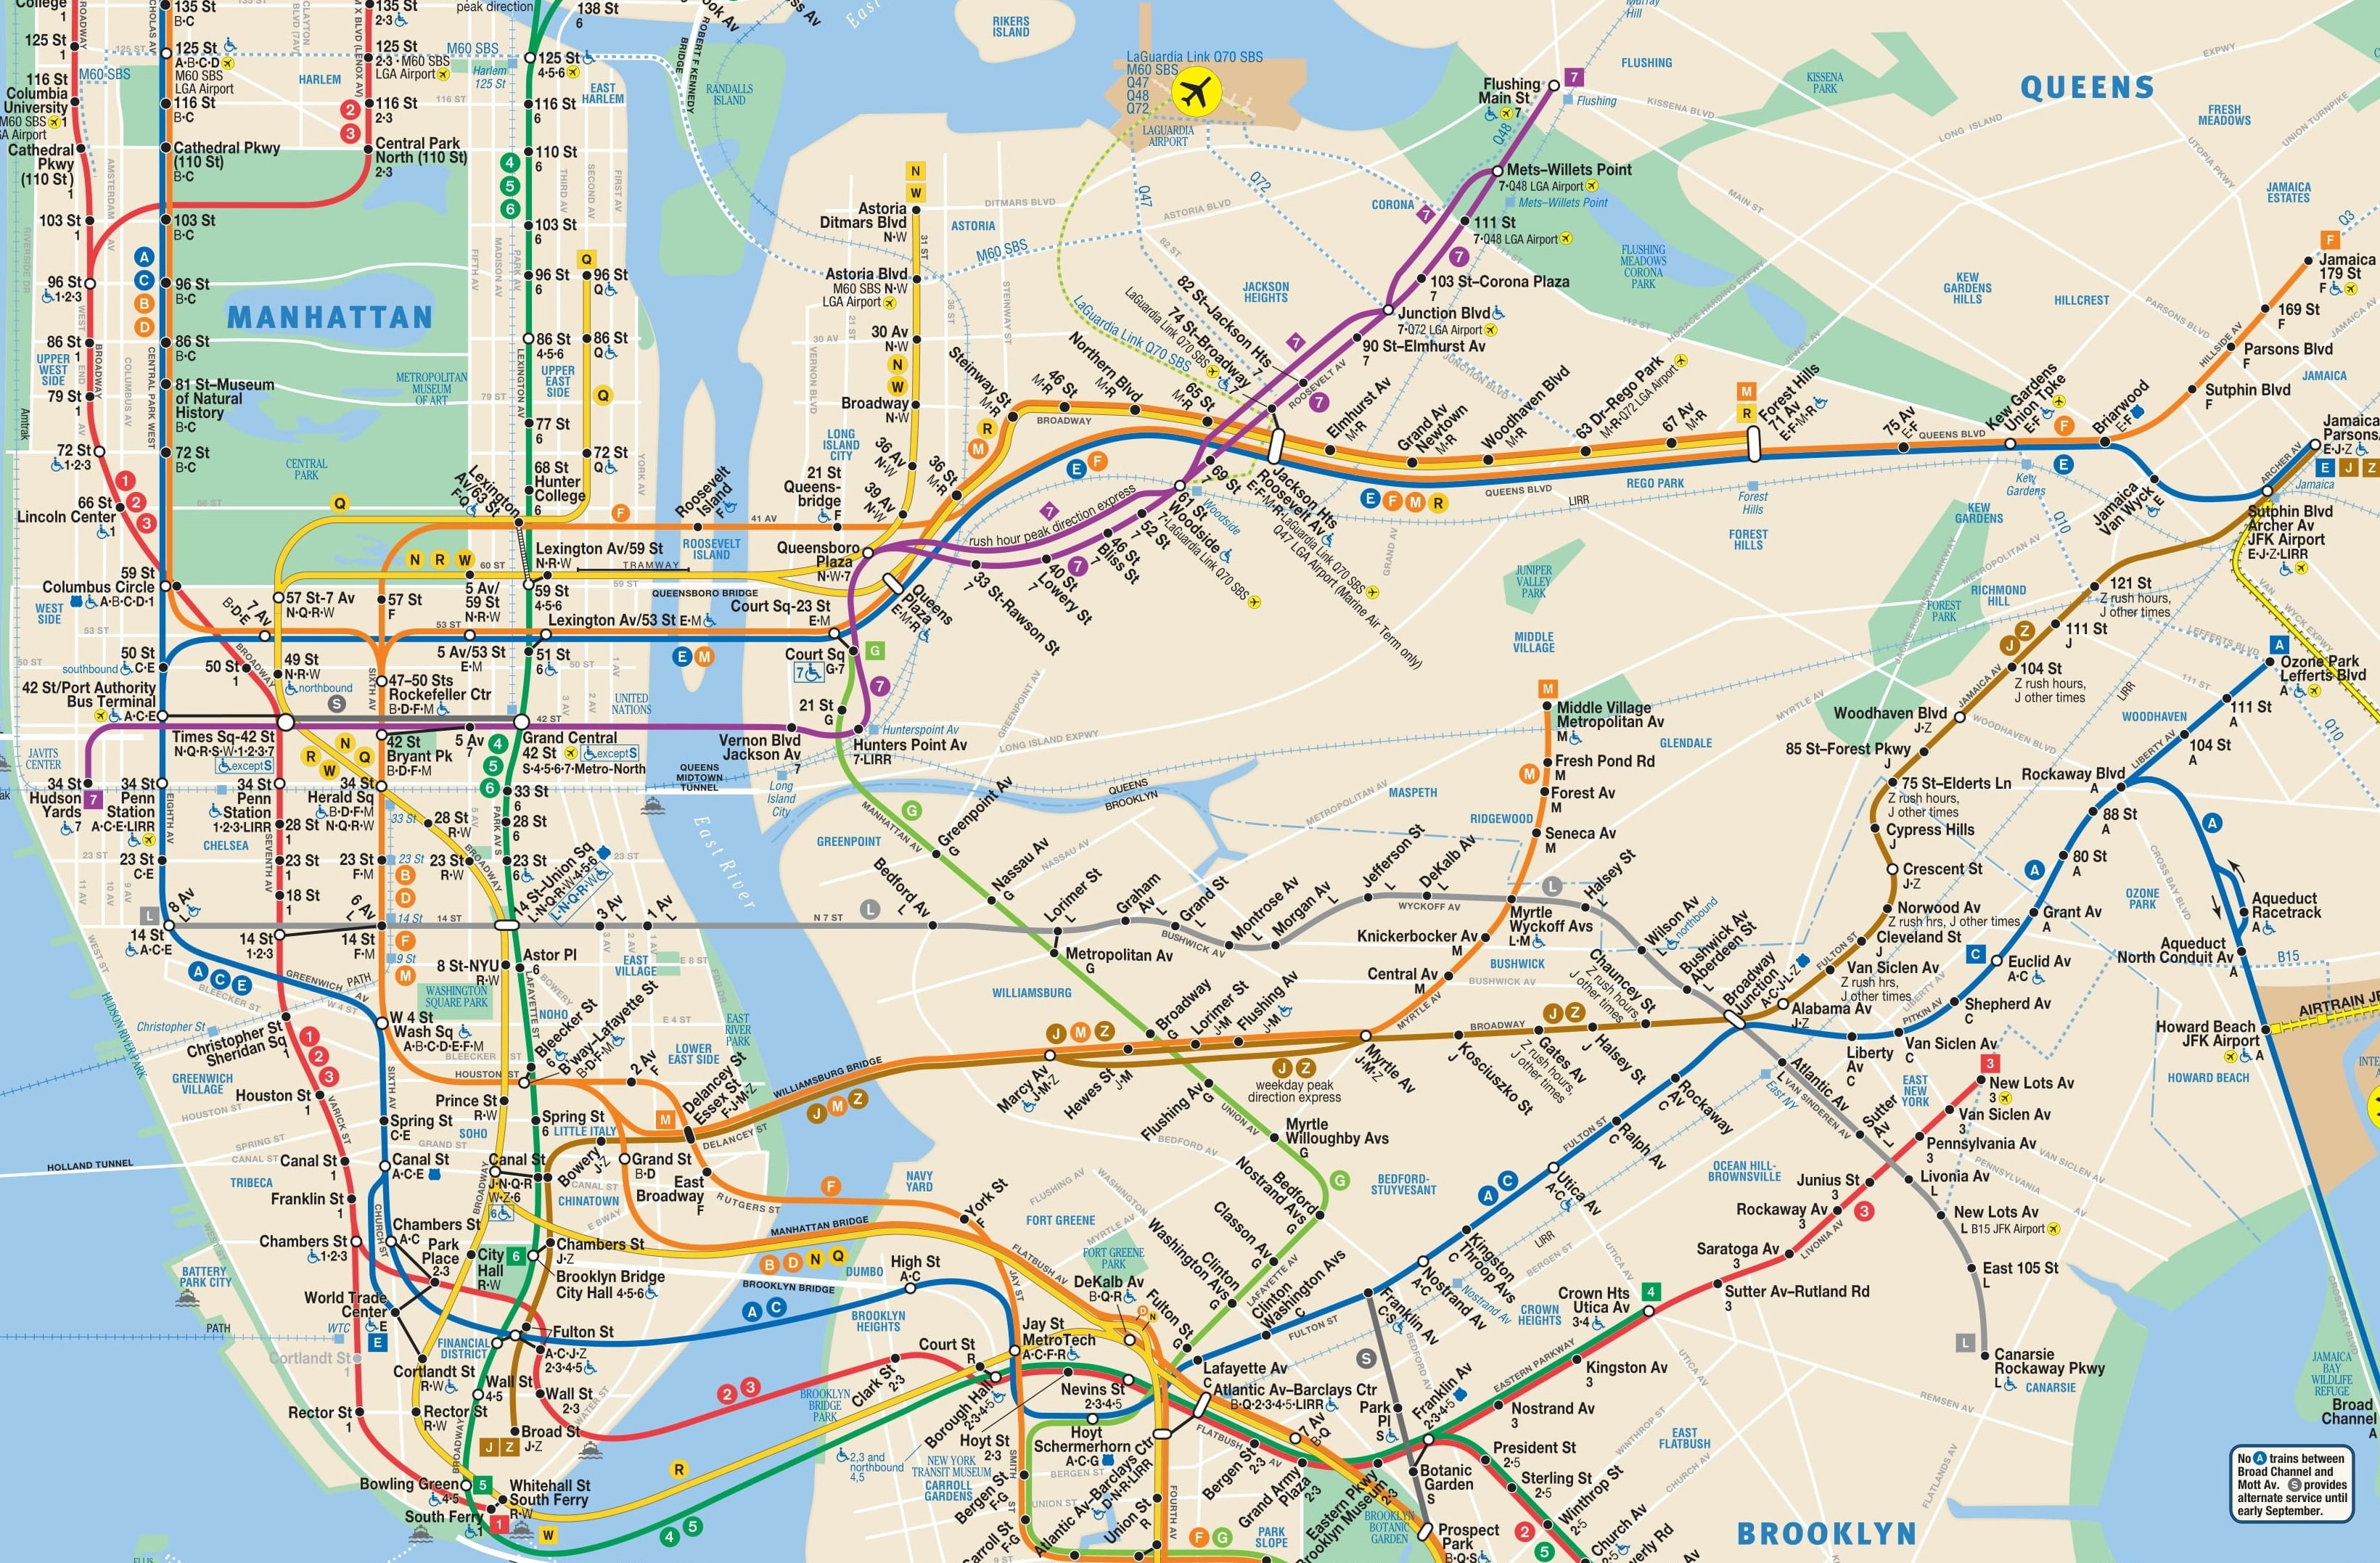

In [41]:
from IPython.display import Image
Image(filename="D:/MTA/subway_map-2.jpg",width=1000)

#### Photo Credit to MTA.info

# Scraping the Data

##### Our data will be obtained from MTA.info's Open Data, using the HTML interpreter package BeautifulSoup. 

In [72]:
from IPython.display import Image
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import pandas as pd
import numpy as np
import pickle
import time
import re
import os
f_path = os.path.join(*['D:', 'MTA'])

In [ ]:
fullTimeTable = pd.DataFrame()
dailyTurnstileCounts = pd.DataFrame()
dataLinks = []

#Start at the Base Page
url = 'http://web.mta.info/developers/turnstile.html'
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)

In [ ]:
#Build List of Data Links
for link in soup.find_all('a'):
    link = str(link)
    if "data/nyct/turnstile/turnstile_" in link:
        weekNum = re.findall('\d+', link)
        dataLinks.append("http://web.mta.info/developers/data/nyct/turnstile/turnstile_"+weekNum[0]+".txt")

In [ ]:
i=0
#Build Full Turstile Data Table
for weekGoingBack in dataLinks[0:54]:
    i=i+1
    url = weekGoingBack
    data = pd.read_csv(url, sep=",")
    print(data)
    print("\n"+"i = "+str(i)+" WEEKS HAVE BEEN PRINTED"+"\n")
    fullTimeTable = pd.concat([fullTimeTable,data])
    del data
    
fullTimeTable.to_pickle('D:/MTA/fullTimeTable.pickle')

# Deciphering the Open Data

In [73]:
fullTimeTable = pd.read_pickle('D:/MTA/fullTimeTable.csv')

In [74]:
print(len(fullTimeTable))
fullTimeTable.head()

10287608


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/04/2018,00:00:00,REGULAR,6712718,2275117
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/04/2018,04:00:00,REGULAR,6712728,2275119
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/04/2018,08:00:00,REGULAR,6712744,2275141
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/04/2018,12:00:00,REGULAR,6712802,2275196
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/04/2018,16:00:00,REGULAR,6712978,2275242


##### From the above table, we can see that there is a generous amount of starting data supplied for our analysis:
-'C/A' refers to and is negligible. 'UNIT' is the part of the corresponding station ('STATION') where the row's device, 'SCP' is located in.

-'LINENAME' lists all the trains available to be ridden from this station, in a single string.

-'DIVISION' is a vague representation of the historic train line the station passes through.

-'DESC' states whether the device is working properly, and we will consider only the ones in 'REGULAR' operation.

-'ENTRIES' and 'EXITS' counts appear cumulative for a certain device. They not only build through the day but continue higher the next day. A differencing operation will be necessary to further investigate these.

-'TIME' blocks are appear four hours apart, but we need to be careful and look at all of the possible unique times.

In [75]:
fullTimeTable=fullTimeTable.rename(columns={'EXITS                                                               ':'EXITS'})

In [76]:
fullTimeTable=fullTimeTable[fullTimeTable['DESC']!='RECOVR AUD']

In [77]:
# CONVERT DATE COLUMN TO PANDAS DATETIME FORMAT
fullTimeTable['DATE']=pd.to_datetime(fullTimeTable['DATE'],infer_datetime_format=True)

In [78]:
fullTimeTable = fullTimeTable.sort_values(by=['STATION','UNIT','SCP','DATE','TIME']).reset_index(drop=True)

In [81]:
# ORGANIZE AND GROUP THE TABLE FOR HANDY MANIPULATION
grouped = fullTimeTable.groupby(['STATION','UNIT','SCP','DATE']) 

fullTimeTable['resetEntries']=fullTimeTable['ENTRIES']-grouped['ENTRIES'].transform('first')
fullTimeTable['resetExits']=fullTimeTable['ENTRIES']-grouped['ENTRIES'].transform('first')

##### After sorting the table in the view of a certain device's chronological buildup of enteries, there appear to be some days where the entry/exit columns plummet to lesser (and potentially negative) number in the midst of the day: this is an error. 
##### Unfortunately, there is not enough information to impute this data. However, we can continue by filtering our set to only the groupings that increase in these numbers.

In [82]:
# KEEP ONLY THE GROUPS WITH resetEntries/resetExits THAT ARE NOT DECREASING
def monotonic(x):
    return np.all(np.diff(x) >= 0)

fullTimeTable=fullTimeTable.groupby(['STATION','UNIT','SCP','DATE']).filter(lambda x: monotonic(x['resetEntries']))
print(len(fullTimeTable))
fullTimeTable=fullTimeTable.groupby(['STATION','UNIT','SCP','DATE']).filter(lambda x: monotonic(x['resetExits']))
print(len(fullTimeTable))

10157432
10157432


##### What if we want a feature that says how many entered or exited the turnstile in a specific time block? We'll use pandas' differencing function.

In [83]:
# NEW ENTRIES/EXITS BY TIME BLOCK: USES pd.diff() FUNCTION TO SUBTRACT SUCCESSIVE ROWS#
fullTimeTable['New Entries by Time Block']= fullTimeTable['resetEntries'].diff(-1)*(-1) 
fullTimeTable['New Exits by Time Block']= fullTimeTable['resetExits'].diff(-1)*(-1)

##### There still appear to be a few dilemmas: 
1) When we difference, the last time block's New Entries/Exits are flawed because it is based on the beginning of the next grouping.

2) There are a lot of time block systems in different devices that aren't {00:00-4:00-16:00-20:00} (though they are still four hour blocks).

3) A last hour block may end at, say 21:00:00 and its count may contain entries from 00:00:00-01:00:00 of the next day. We don't know how much of the difference belongs to the last block of the initial day rather than to the first block of the next day.

To solve this, we can create a column representing the proportion-of-four-hours the last block of the current day takes up.
Not only will this limit how many entries/exits of the last time block we take, but we can calculate how much belongs to the next day and consider that when calculating the totals for it.

In [84]:
# CALCULATE THE PROPORTION BELONGING TO LAST BLOCK RATHER THAN NEXT DAY (e.g. 23:00:00->03:00:00)
fullTimeTable['hourNum']=fullTimeTable['TIME'].apply(lambda x: int(x[0:2]))
fullTimeTable['proportion']= fullTimeTable['hourNum'].apply(lambda x: (24-x)/4 if x>20 else 1)

In [85]:
# CORRECT EACH DAY'S LAST BLOCK:
fullTimeTable.loc[fullTimeTable['hourNum']>=20,'New Entries by Time Block'] = fullTimeTable['ENTRIES'].diff(-1)*(-1) 
fullTimeTable.loc[fullTimeTable['hourNum']>=20,'New Exits by Time Block']   = fullTimeTable['EXITS'].diff(-1)*(-1)

In [86]:
# CALCULATE THE HIDDEN COUNTS FROM MISSED HOURS OF THE NEXT MORNING
fullTimeTable.loc[:,'hiddenEntsNextDay']=fullTimeTable.loc[:,'New Entries by Time Block']*(1-fullTimeTable.loc[:,'proportion'])
fullTimeTable.loc[:,'hiddenExitsNextDay']=fullTimeTable.loc[:,'New Exits by Time Block']*(1-fullTimeTable.loc[:,'proportion'])

In [87]:
# TAKE AWAY COUNTS FROM THE LAST BLOCK THAT BELONG TO THE NEXT DAY
fullTimeTable.loc[:,'New Entries by Time Block']=fullTimeTable.loc[:,'New Entries by Time Block']*fullTimeTable.loc[:,'proportion']
fullTimeTable.loc[:,'New Exits by Time Block']=fullTimeTable.loc[:,'New Exits by Time Block']*fullTimeTable.loc[:,'proportion']

In [21]:
fullTimeTable.loc[1221:1227,['DATE','SCP','ENTRIES','resetEntries','New Entries by Time Block','hourNum','Total Daily Entries','hiddenEntsNextDay']].head(50)

,DATE,SCP,ENTRIES,resetEntries,New Entries by Time Block,hourNum,Total Daily Entries,hiddenEntsNextDay
1221,2018-03-02,00-00-00,13268218,0,86.0,3,NaN,0.0
1222,2018-03-02,00-00-00,13268304,86,1259.0,7,NaN,0.0
1223,2018-03-02,00-00-00,13269563,1345,757.0,11,NaN,0.0
1224,2018-03-02,00-00-00,13270320,2102,1195.0,15,NaN,0.0
1225,2018-03-02,00-00-00,13271515,3297,598.0,19,NaN,0.0
1226,2018-03-02,00-00-00,13272113,3895,44.5,23,NaN,133.5
1227,2018-03-03,00-00-00,13272291,0,42.0,3,NaN,0.0


In [88]:
#fullTimeTable=fullTimeTable.reset_index(drop=True)
fullTimeTable.to_pickle('D:/MTA/fullTimeTable.pickle')
#fullTimeTable = pd.read_pickle('D:/MTA/fullTimeTable.pickle')

# Cleaning and Aggregating the Data

#### Now that we can observe the existing data in more depth, we can add onto it and check it for hidden errors.

In [14]:
fullTimeTable = pd.read_pickle('D:/MTA/fullTimeTable.pickle')

In [17]:
# SET DIRTY DATA NaN or IMPUTE. CAN BE UNKNOWN DUE TO INCONSISTENCIES.
# NEXT DAY'S STARTING COUNT CAN JUMP THOUSANDS WHILE IT'S ENDING DATA CAN BE NEGATIVE
print(len(fullTimeTable[(fullTimeTable['resetEntries']<0)]))
print(len(fullTimeTable[(fullTimeTable['resetExits']<0)]))
print('\n')
print(len(fullTimeTable[(fullTimeTable['New Exits by Time Block']<0)]))
print(len(fullTimeTable[(fullTimeTable['New Entries by Time Block']<0)]))
print('\n')
print(len(fullTimeTable[(fullTimeTable['New Exits by Time Block']>1000)]))
print(len(fullTimeTable[(fullTimeTable['New Entries by Time Block']>1000)]))
print('\n')
print(len(fullTimeTable[(fullTimeTable['New Exits by Time Block']>1500)]))
print(len(fullTimeTable[(fullTimeTable['New Entries by Time Block']>1500)]))
print('\n')
print(len(fullTimeTable[(fullTimeTable['New Exits by Time Block']>2000)]))
print(len(fullTimeTable[(fullTimeTable['New Entries by Time Block']>2000)]))
print('\n')
print(len(fullTimeTable[(fullTimeTable['New Exits by Time Block']>5000)]))
print(len(fullTimeTable[(fullTimeTable['New Entries by Time Block']>5000)]))
print('\n')
print(len(fullTimeTable[(fullTimeTable['New Exits by Time Block']>10000)]))
print(len(fullTimeTable[(fullTimeTable['New Entries by Time Block']>10000)]))

0
0


19599
14701


186075
188486


47310
48507


15022
16033


4450
5528


3032
3495


In [89]:
# ELIMINATING THE ~20,000/~15,000 NEGATIVE NEW ENTRIES/EXITS
fullTimeTable.loc[(fullTimeTable['New Entries by Time Block']<0),'New Entries by Time Block']=np.nan
fullTimeTable.loc[(fullTimeTable['New Exits by Time Block']<0),'New Exits by Time Block']=np.nan

In [90]:
# MAKE A NEW STATION-UNIT-DEVICE GROUP AT THE END OF ITS DAYS BE NA IN THE LAST BLOCK
fullTimeTable.loc[fullTimeTable['hourNum']>=20 & (fullTimeTable['New Exits by Time Block'].isnull()),'hiddenEntsNextDay']=np.nan
fullTimeTable.loc[fullTimeTable['hourNum']>=20 & (fullTimeTable['New Exits by Time Block'].isnull()),'hiddenExitsNextDay']=np.nan

#### There are still many outliers - over 15,000 New Entries by Time Block and 16,033 New Exits by Time Block above 2,000. What is leading to that?

In [39]:
fullTimeTable[(fullTimeTable['New Entries by Time Block']>10000)].head(2)
#fullTimeTable.loc[fullTimeTable['hourNum']>=20 & ((fullTimeTable['New Entries by Time Block']<0) | (fullTimeTable['New Entries by Time Block']>2000)),'hiddenEntsNextDay']=np.nan
#fullTimeTable.loc[fullTimeTable['hourNum']>=20 & ((fullTimeTable['New Exits by Time Block']<0) | (fullTimeTable['New Exits by Time Block']>2000)),'hiddenExitsNextDay']=np.nan

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,resetEntries,resetExits,New Entries by Time Block,New Exits by Time Block,hourNum,proportion,hiddenEntsNextDay,hiddenExitsNextDay
42,H007,R248,00-00-00,1 AV,L,BMT,2017-08-04,20:00:00,REGULAR,12589534,13930979,3288,3288,22808.0,30212.0,20,1.0,NaN,NaN
2191,H007,R248,00-00-00,1 AV,L,BMT,2018-08-10,20:00:00,REGULAR,13832145,15514911,3443,3443,43694242.0,21142768.0,20,1.0,NaN,NaN


In [150]:
fullTimeTable.loc[472962:472964,:]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,resetEntries,resetExits,New Entries by Time Block,New Exits by Time Block,hourNum,proportion,hiddenEntsNextDay,hiddenExitsNextDay,index
472962,A035,R170,00-00-01,14 ST-UNION SQ,LNQR456W,BMT,2018-03-18,13:00:00,REGULAR,211428,766592,59,59,NaN,NaN,13,1.0,NaN,NaN,472962
472963,A035,R170,00-00-01,14 ST-UNION SQ,LNQR456W,BMT,2018-03-22,05:00:00,REGULAR,211470,772881,0,0,-0.0,-0.0,5,1.0,NaN,NaN,472963
472964,A035,R170,00-00-01,14 ST-UNION SQ,LNQR456W,BMT,2018-03-28,01:00:00,REGULAR,211542,784597,0,0,42.0,42.0,1,1.0,NaN,NaN,472964


In [91]:
fullTimeTable['index']=fullTimeTable.index

#### It appears that it stays on the same device, but jumps a bunch of dates. Let's re-sort it again and see.
#### After sorting, we see that this happens when a row with new device in the table is reached too.

In [92]:
# SET NEW ENTS/EXITS OF LAST HOUR OF LAST DAY OF EACH DEVICE to np.nan
lastVals=fullTimeTable.groupby(['STATION','UNIT','SCP']).last()[['New Entries by Time Block','New Exits by Time Block','index']]# = np.nan()#'New Exits By Time Block']]
npNaNTheseIndices=lastVals['index']
len(npNaNTheseIndices)

4840

In [83]:
# JUST CHECKING:
fullTimeTable.loc[npNaNTheseIndices,['New Entries by Time Block','New Exits by Time Block']].head(10)

,New Entries by Time Block,New Exits by Time Block
2191,43694242.0,21142768.0
4383,310863979.0,349626581.0
6576,NaN,NaN
8768,3383843.0,NaN
10960,NaN,1219014.0
13148,2095234.0,9852139.0
15336,5740696.0,5192438.0
17515,953596006.0,997270711.0
19703,672736577.0,NaN
21884,NaN,336565458.0


In [93]:
fullTimeTable.loc[npNaNTheseIndices,['New Entries by Time Block','New Exits by Time Block']]=np.nan

In [24]:
print(len(fullTimeTable[(fullTimeTable['New Exits by Time Block']>1000)]))
print(len(fullTimeTable[(fullTimeTable['New Entries by Time Block']>1000)]))
print('\n')
print(len(fullTimeTable[(fullTimeTable['New Exits by Time Block']>1500)]))
print(len(fullTimeTable[(fullTimeTable['New Entries by Time Block']>1500)]))
print('\n')
print(len(fullTimeTable[(fullTimeTable['New Exits by Time Block']>2000)]))
print(len(fullTimeTable[(fullTimeTable['New Entries by Time Block']>2000)]))

183954
186337


45206
46359


12928
13888


In [94]:
fullTimeTable[(fullTimeTable['New Entries by Time Block']>2000)]['STATION'].value_counts()[0:10]

GRD CNTRL-42 ST    2048
34 ST-PENN STA     1143
34 ST-HERALD SQ    1134
59 ST COLUMBUS      914
14 ST-UNION SQ      912
BROADWAY            424
42 ST-PORT AUTH     379
14 ST               238
57 ST-7 AV          226
47-50 STS ROCK      189
Name: STATION, dtype: int64

In [100]:
fullTimeTable[(fullTimeTable['New Entries by Time Block']>5000)].head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,resetEntries,resetExits,New Entries by Time Block,New Exits by Time Block,hourNum,proportion,hiddenEntsNextDay,hiddenExitsNextDay,index
42,H007,R248,00-00-00,1 AV,L,BMT,2017-08-04,20:00:00,REGULAR,12589534,13930979,3288,3288,22808.0,30212.0,20,1.00,NaN,NaN,42
889,H007,R248,00-00-00,1 AV,L,BMT,2017-12-29,23:00:00,REGULAR,13059788,14564171,2870,2870,5189.0,5351.5,23,0.25,NaN,NaN,889
2234,H007,R248,00-00-01,1 AV,L,BMT,2017-08-04,20:00:00,REGULAR,57554976,36670390,4190,4190,30002.0,14120.0,20,1.00,NaN,NaN,2234


In [40]:
print(len(fullTimeTable[(fullTimeTable['New Entries by Time Block']>=3000)&(fullTimeTable['hourNum']<20)]))
print(len(fullTimeTable[(fullTimeTable['New Entries by Time Block']>=3000)&(fullTimeTable['hourNum']>=20)]))

683
4583


#### Notice just above that there is a difference when looking at the end of a day rather than in the midst. This is because a new day may imply a new device with a different entry count system. There could also be days skipped!

In [39]:
fullTimeTable[(fullTimeTable['New Entries by Time Block']>=3000)&(fullTimeTable['hourNum']<20)].head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,resetEntries,resetExits,New Entries by Time Block,New Exits by Time Block,hourNum,proportion,hiddenEntsNextDay,hiddenExitsNextDay,index
302549,R305,R206,01-00-00,125 ST,23,IRT,2017-08-15,05:00:00,REGULAR,559485,297541,28,28,133665112.0,133665112.0,5,1.0,NaN,NaN,302549
304795,R305,R206,01-00-01,125 ST,23,IRT,2017-08-15,09:00:00,REGULAR,1672376,660532,177,177,417806564.0,417806564.0,9,1.0,NaN,NaN,304795
355035,N022,R332,02-05-01,135 ST,BC,IND,2018-07-04,01:00:00,REGULAR,541,371,0,0,523747.0,523747.0,1,1.0,NaN,NaN,355035


#### There are still many outliers. It seems the problem is that rows sometimes skip a bunch of days, mainly due to missing data for a device. But sometimes, like below when looking in the midst of a day, there is no explanation for the massive entries jump!

In [43]:
fullTimeTable.loc[516542:516545,['DATE','TIME','ENTRIES','New Entries by Time Block']]

,DATE,TIME,ENTRIES,New Entries by Time Block
516542,2018-05-10,05:00:00,1487691,1.510000e+02
516543,2018-05-10,09:00:00,1487842,1.159530e+08
516544,2018-05-10,17:00:00,117440798,6.820000e+02
516545,2018-05-10,21:00:00,117441480,1.912500e+02


#### To solve this, we will need to use the best of our judgement and np.NaN all above the new entry or exit count of 3000.

In [95]:
fullTimeTable.loc[((fullTimeTable['New Entries by Time Block']>=3000)|(fullTimeTable['New Exits by Time Block']>=3000)),['New Entries by Time Block','New Exits by Time Block']]=np.nan

In [96]:
fullTimeTable=fullTimeTable.reset_index(drop=True)
fullTimeTable.to_pickle('D:/MTA/fullTimeTable.pickle')

In [46]:
len(fullTimeTable)

10157432

### We are now ready to use GroupBy again to calculate the totals of a certain device's daily entries/exits.

In [97]:
# GROUP FOR AGGREGATION
grouped = fullTimeTable.reset_index(drop=True).groupby(['STATION','UNIT','SCP','DATE']) 

totDailyEntries        = grouped['New Entries by Time Block'].sum(skipna=True)
totDailyExits          = grouped['New Exits by Time Block'].sum(skipna=True)
addHiddenEntsToTotals  = grouped['hiddenEntsNextDay'].sum(skipna=True).shift(1)
addHiddenExitsToTotals = grouped['hiddenExitsNextDay'].sum(skipna=True).shift(1)

In [98]:
# UPDATE THE DAILY TOTALS WITH THESE HIDDEN COUNTS
totDailyEntries=totDailyEntries+addHiddenEntsToTotals
totDailyExits=totDailyExits+addHiddenExitsToTotals

totDailyEntries=totDailyEntries.reset_index().rename(columns={0: 'Total Daily Entries'})
totDailyExits=totDailyExits.reset_index().rename(columns={0: 'Total Daily Exits'})

In [99]:
# ADD TOTAL DAILY ENTRIES COLUMN
fullTimeTable=fullTimeTable.merge(totDailyEntries)

In [100]:
# ADD TOTAL DAILY EXITS COLUMN
fullTimeTable=fullTimeTable.merge(totDailyExits)

In [101]:
# TOTAL FINAL RIDERSHIP FOR THE DAY
fullTimeTable['Total Daily Rides']=fullTimeTable['Total Daily Entries']+fullTimeTable['Total Daily Exits']

In [102]:
len(fullTimeTable)

10157432

In [54]:
# CHECKING FOR THESE CONDITIONS:
print(len(fullTimeTable[fullTimeTable['Total Daily Entries']<0]))
print(len(fullTimeTable[fullTimeTable['Total Daily Exits']<0]))
print(len(fullTimeTable[fullTimeTable['Total Daily Entries']==0]))
print(len(fullTimeTable[fullTimeTable['Total Daily Exits']==0]))

0
0
1059163
969980


In [55]:
len(fullTimeTable[(fullTimeTable['Total Daily Entries']==0)|(fullTimeTable['Total Daily Exits']==0)])

1070320

#### There appear to be far too many (over a million!) rows for devices that do not register and entry/exit data. For our analytical interest, finding what maximizes the count, these turnstiles are useless. Therefore, it is okay to drop them.

In [103]:
# DROPPING MISSING TURNSTILES DATA - THEY DON'T COUNT BECAUSE THEY MISREPRESENT OUR DATA
fullTimeTable=fullTimeTable[(fullTimeTable['Total Daily Entries']>0)&(fullTimeTable['Total Daily Exits']>0)].reset_index(drop=True)

In [104]:
fullTimeTable=fullTimeTable.reset_index(drop=True)
fullTimeTable.to_pickle('D:/MTA/fullTimeTable.pickle')

# Examining the Deeper Data

In [58]:
# Average up the daily ride totals by station's devices.
stationTotRideAvgs = fullTimeTable.groupby(['STATION'])['Total Daily Rides'].sum()
stationTotRideAvgs.sort_values(ascending=False).head()

STATION
34 ST-PENN STA     6.039143e+08
GRD CNTRL-42 ST    5.145609e+08
34 ST-HERALD SQ    4.056924e+08
23 ST              3.944755e+08
14 ST-UNION SQ     3.827067e+08
Name: Total Daily Rides, dtype: float64

In [61]:
stationTotRideAvgs = fullTimeTable.groupby(['STATION'])['Total Daily Rides'].mean()
stationTotRideAvgs.sort_values(ascending=False).head()

STATION
YORK ST           5939.005432
MYRTLE AV         5667.306241
14 ST-UNION SQ    4749.636346
GATES AV          4582.840707
QUEENSBORO PLZ    4511.868576
Name: Total Daily Rides, dtype: float64

# Feature Engineering Part I: Features Depending on Station

#### The station name is one of the few supplied features relating to external information of the outside world that can impact turnstile counts. We can gather more information about it to engineer features that will improve our predictive power, starting from its location.

#### With GeoCoder, we can extract its map coordinates by searching the station name on Google Maps.

In [62]:
import pandas as pd

In [187]:
stationInfo = pd.DataFrame(fullTimeTable[['STATION','LINENAME']].drop_duplicates().values.astype(str),columns=['STATION','Trains'])
stationInfo=stationInfo.drop_duplicates(subset='STATION').reset_index(drop=True)
#stationInfo.to_pickle(path=saveToThisPath+'stationInfo.pickle')
#stationInfo=pd.read_pickle(path=saveToThisPath+'stationInfo.pickle')

# LATITUDE and LONGITUDE
from pygeocoder import Geocoder

stationInfo.to_pickle('stationInfo.csv')

stationInfo['Latitude']=""
stationInfo['Longitude']=""
stationInfo['Coordinates'] = ""

          STATION        Trains Latitude Longitude                Coordinates
0           59 ST       NQR456W  40.7617   -73.967  (40.7617367, -73.9669511)
1      5 AV/59 ST          NQRW  40.7643   -73.973  (40.7643054, -73.9730051)
2      57 ST-7 AV          NQRW  40.7656  -73.9803   (40.765564, -73.9803309)
3           49 ST          NQRW  40.7621  -73.9877  (40.7621246, -73.9876635)
4  TIMES SQ-42 ST  ACENQRS1237W  40.7559  -73.9871   (40.7558611, -73.987061)


In [273]:
for i in range(0,len(stationInfo)):
    coordinates=Geocoder().geocode(stationInfo.loc[i,'STATION']+", New York, NY")[0].coordinates
    stationInfo.loc[i,'Coordinates']=str(coordinates)
    stationInfo.loc[i,'Latitude']=coordinates[0]
    stationInfo.loc[i,'Longitude']=coordinates[1]
    print(len(stationInfo[stationInfo['Coordinates']!=""]))
    
stationInfo.to_pickle('stationInfo.csv')

print(stationInfo.head())

479
479
479
479
479
479
479
          STATION        Trains Latitude Longitude                Coordinates
0           59 ST       NQR456W  40.7617   -73.967  (40.7617367, -73.9669511)
1      5 AV/59 ST          NQRW  40.7643   -73.973  (40.7643054, -73.9730051)
2      57 ST-7 AV          NQRW  40.7656  -73.9803   (40.765564, -73.9803309)
3           49 ST          NQRW  40.7621  -73.9877  (40.7621246, -73.9876635)
4  TIMES SQ-42 ST  ACENQRS1237W  40.7559  -73.9871   (40.7558611, -73.987061)


#### Tracking the borough or part of a borough the station is in can help us narrow what we're looking at, as places in New York City just a mile apart can vary so much.

In [28]:
# BOROUGH
from geopy.geocoders import Nominatim
geolocator = Nominatim()
coordList = stationInfo[['Latitude','Longitude']].values.tolist()

def coordInfo(c):
    borough = str(geolocator.reverse(c)).split(', ')
    return borough

geolocator.reverse(coordList[0])

C:\Users\ericn\Anaconda3\lib\site-packages\geopy\geocoders\osm.py:138: UserWarning: Using Nominatim with the default "geopy/1.16.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


Location(Bloomingdale's, East 59th Street, Upper East Side, Midtown East, Manhattan, Manhattan Community Board 6, New York County, NYC, New York, 10022, United States of America, (40.76221035, -73.9671743455906, 0.0))

In [31]:
list1=   list(map(coordInfo,coordList[0:50]))

In [33]:
list2 =  list(map(coordInfo,coordList[51:100]))

In [35]:
list3 =  list(map(coordInfo,coordList[101:150]))

In [36]:
list4 =  list(map(coordInfo,coordList[151:200]))

In [38]:
list5 =  list(map(coordInfo,coordList[201:250]))

In [39]:
list6 =  list(map(coordInfo,coordList[251:300]))

In [40]:
list7 =  list(map(coordInfo,coordList[301:350]))

In [41]:
list8 =  list(map(coordInfo,coordList[351:400]))

In [42]:
list9 =  list(map(coordInfo,coordList[401:450]))

In [43]:
list10 =  list(map(coordInfo,coordList[451:479]))

In [ ]:
bigList=list1+list2+list3+list4+list5+list6+list7+list8+list9+list10

In [ ]:
stationInfo['Borough'] = pd.DataFrame(bigList).loc[:,3]

In [51]:
stationInfo.to_pickle('D:/MTA/stationInfo.pickle')

In [52]:
stationInfo.head()

,STATION,Trains,Latitude,Longitude,Coordinates,Borough
0,59 ST,NQR456W,40.7617,-73.967,"(40.7617367, -73.9669511)",Midtown East
1,5 AV/59 ST,NQRW,40.7643,-73.973,"(40.7643054, -73.9730051)",Upper East Side
2,57 ST-7 AV,NQRW,40.7656,-73.9803,"(40.765564, -73.9803309)",Manhattan
3,49 ST,NQRW,40.7621,-73.9877,"(40.7621246, -73.9876635)",Manhattan
4,TIMES SQ-42 ST,ACENQRS1237W,40.7559,-73.9871,"(40.7558611, -73.987061)",Manhattan


#### The distance to the closest station may impact whether a passenger will choose to take a train to get somewhere, rather than walk or take a taxi/Uber/Lyft instead. 

In [347]:
stationInfo=stationInfo.drop_duplicates(subset='STATION').reset_index(drop=True)

In [348]:
from math import sin, cos, sqrt, atan2
import pandas as pd
import numpy as np
import geopy.distance

def dist(lat1, long1, lat2, long2):
    coords_1=[lat1,long1]
    coords_2=[lat2,long2]
    return geopy.distance.vincenty(coords_1, coords_2).m
    
def find_closest_station(lat, long):
    distances = stationInfo.apply(lambda row: dist(lat, long, row['Latitude'], row['Longitude']), axis=1)
    return stationInfo.loc[distances.nsmallest(2).index.values[1], 'STATION']

def dist_to_closest(lat, long):
    distances = stationInfo.apply(lambda row: dist(lat, long, row['Latitude'], row['Longitude']), axis=1)
    return distances.nsmallest(2).values[1]

stationInfo['ClosestStation']=stationInfo[['Latitude','Longitude']].apply(lambda row: find_closest_station(row['Latitude'], row['Longitude']), axis=1)
stationInfo['distToClosestStation']=stationInfo[['Latitude','Longitude']].apply(lambda row: dist_to_closest(row['Latitude'], row['Longitude']), axis=1)



In [351]:
stationInfo['distToClosestStation'].sort_values(ascending=False).head()

373    98074.283935
248    98074.283935
205    19674.772636
237    13026.489971
113     4114.183269
Name: distToClosestStation, dtype: float64

In [352]:
stationInfo.loc[[373,248,205,237],:]

,STATION,Trains,Latitude,Longitude,Coordinates,Borough,ClosestStation,distToClosestStation,1,2,...,F,G,J,L,M,N,Q,R,S,W
373,RIT-MANHATTAN,R,43.0846,-77.6743,"(43.0845894, -77.67434449999999)",Manhattan,LACKAWANNA,98074.283935,0,0,...,0,0,0,0,0,0,0,1,0,0
248,LACKAWANNA,1,42.8256,-78.8234,"(42.8256141, -78.8233664)",Financial District,RIT-MANHATTAN,98074.283935,1,0,...,0,0,0,0,0,0,0,0,0,0
205,BROADWAY,G,41.1115,-73.8584,"(41.1115472, -73.85838059999999)",BK,HARRISON,19674.772636,0,0,...,0,1,0,0,0,0,0,0,0,0
237,HARRISON,1,40.97,-73.7176,"(40.9700171, -73.7176337)",Manhattan,ORCHARD BEACH,13026.489971,1,0,...,0,0,0,0,0,0,0,0,0,0
113,FOREST AVE,M,40.6256,-74.135,"(40.6255926, -74.13504069999999)",Middle Village,TOMPKINSVILLE,4114.183269,0,0,...,0,0,0,0,1,0,0,0,0,0


In [353]:
stationInfo.loc[[373,248,205,237],:]=np.nan

#### The availiability of a train one needs to take to get to their destination may impact if the rider chooses to enter that station over another. We will One Hot Encode a binary feature for the availability of each of the 22 trains in a row's station.

In [54]:
# Add takeable-Trains in Station? OneHotEncode.
trainList = ['1','2','3','4','5','6','7','A','B','C','D','E','F','G','J','L','M','N','Q','R','S','W']
for t in trainList:
    stationInfo[t]= stationInfo['Trains'].apply(lambda x: 1 if t in x else 0)

In [ ]:
# OTHER POTENTIAL FEATURES WORTH OF ENGINEERING:

#['On E Line','On F Line',''On F Line']
# Num Stops to Penn
# Num Stops to GC
# Num Stops to TimesSq
# WHETHER ONE OF THESE IS REACHABLE BY DIRECTLY TAKING THIS STATION

#### Finally, we merge this onto the original table by the corresponding station.

In [357]:
len(stationInfo)

379

In [354]:
stationInfo.to_pickle('D:/MTA/stationInfo.pickle')

In [4]:
stationInfo=pd.read_pickle('D:/MTA/stationInfo.pickle')

In [3]:
import pandas as pd
fullTimeTable=pd.read_pickle('D:/MTA/fullTimeTable.pickle')

In [5]:
fullTimeTable=fullTimeTable.drop(['distToClosestStation','ClosestStation'],axis=1)

In [6]:
fullTimeTable=fullTimeTable.reset_index(drop=True).merge(stationInfo)
len(fullTimeTable)

8994256

# Feature Engineering Part II: Features Depending on Day

#### Of course, we also intend to see how time features relate to entry.

In [ ]:
from datetime import datetime
from dateutil.parser import parse
dailyTable=pd.DataFrame(fullTimeTable['DATE'].drop_duplicates().values,columns=['Date'])
dailyTable['datetime']=[datetime.strptime(x, '%m/%d/%Y') for x in dailyTable['Date']]

#Add Weekday Column
dailyTable['Weekday'] = dailyTable['datetime'].dt.weekday_name

#Add Month Column
dailyTable['Mo'] = dailyTable['datetime'].dt.month

#Add Holiday Or Not Column
holidays = calendar().holidays(start=dailyTable['datetime'].min(), end=dailyTable['datetime'].max())
dailyTable['Holiday'] = dailyTable['datetime'].isin(holidays)

#### How hot or cold it is and whether its raining or snowing a lot can impact the turnout at a station, or even in the subway as a whole.

In [ ]:
#Scrape the Mean Daily Temperature and Mean Precipitation
from WunderWeather import weather
from pprint import pprint
import arrow
extractor = weather.Extract('ce9f876ace16df4b') # API KEY

def getWeather(d):
    date = arrow.get(d,"MM/DD/YYYY")
    location = "NY/New York"
    response = extractor.date(location,date.format('YYYYMMDD'))
    return response.data['dailysummary'][0]['meantempi'],response.data['dailysummary'][0]['precipi']

dailyTable['Avg Temperature']=dailyTable['Date'].apply(lambda d: getWeather(d)[0])
dailyTable['Precipitation']=dailyTable['Date'].apply(lambda d: getWeather(d)[1])

In [ ]:
saveToThisPath = "D:/MTA/"
dailyTable.to_pickle(path=saveToThisPath+'dailyTable.pickle')

In [30]:
dailyTable.head()

,Date,datetime,Weekday,Holiday,Avg Temperature,Precipitation
0,08/04/2018,2018-08-04,Saturday,False,78,0.74
1,08/05/2018,2018-08-05,Sunday,False,82,0.00
2,08/06/2018,2018-08-06,Monday,False,85,0.00
3,08/07/2018,2018-08-07,Tuesday,False,82,0.05
4,08/08/2018,2018-08-08,Wednesday,False,83,0.00


#### Finally, we merge this onto the original table by the corresponding date.

In [107]:
dailyTable=pd.read_pickle('D:/MTA/dailyTable.pickle')
fullTimeTable=pd.merge(fullTimeTable,dailyTable, left_on='DATE',right_on='datetime')

In [179]:
len(fullTimeTable)

9087106

In [11]:
fullTimeTable.to_pickle('D:/MTA/fullTimeTable.pickle')